In [1]:
import model
import model_fourier
import baseline_model as baseline
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.layers import *
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

c:\Users\phong\.conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Data preparation

In [2]:
no_of_sensor = 32

In [2]:
# Prepare field data
Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []

for Re in Re_list_train:
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

full_field_data_whole_array = np.concatenate(full_field_data_whole, axis = -1)
min_val = np.amin(full_field_data_whole_array)
max_val = np.amax(full_field_data_whole_array)




In [5]:
# Prepare field data
no_sensor_list = [32]
Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole_test = []
full_field_data_whole = []
for no_of_sensor in no_sensor_list:
    sensor_data_whole_case = []
    for Re in Re_list_test:
        filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
        sensor_data = np.load(filename)
        sensor_data_whole_case.append(sensor_data)
    sensor_data_whole_case = np.swapaxes(np.concatenate(sensor_data_whole_case,axis = -1), 0,1)
    # print(sensor_data_whole_case)
    sensor_data_whole_test.append(sensor_data_whole_case)
# sensor_data_whole_test = np.array(sensor_data_whole)

for Re in Re_list_test:
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

full_field_data_whole_test = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(full_field_data_whole_test.shape)

full_field_data_whole_test_norm = (full_field_data_whole_test - min_val)/(max_val - min_val)
sensor_data_whole_test_norm = []
for i in range(1):
    sensor_data_whole_test_norm_case = (sensor_data_whole_test[i] - min_val)/(max_val - min_val)
    sensor_data_whole_test_norm.append(sensor_data_whole_test_norm_case)

dim = full_field_data_whole_test_norm.shape
x = tf.linspace(0, 1, dim[2])
y = tf.linspace(0, 1, dim[1])
coordX, coordY = np.meshgrid(x, y)
coordX = np.expand_dims(coordX, axis = -1)
coordY = np.expand_dims (coordY, axis = -1)
input_coord = np.concatenate([coordX,coordY], axis = -1)
input_coord = np.repeat(input_coord[np.newaxis,:,:,:], dim[0], axis = 0)


# Test
print("Check field data: ", np.amin(full_field_data_whole_test_norm), np.amax(full_field_data_whole_test_norm))
# print("Check sens data: ", np.amin(sensor_data_whole_test_norm), np.amax(sensor_data_whole_test_norm))

(156, 128, 256, 1)
Check field data:  0.0 0.9929987273789493


In [4]:
len(sensor_data_whole_test)


1

## Load model

In [5]:
#
path = 'E:/Research/Physics-informed-machine-learning/weights/'

### FLRNet

In [6]:
def load_model(no_of_sensor, layout):
    path = 'E:/Research/Physics-informed-machine-learning/weights/'
    # Load FLRNet with perceptual loss
    flow_recon_net = model.FLRNet(n_sensor = no_of_sensor)
    flow_recon_net.encoder.load_weights('E:/Research/Physics-informed-machine-learning/weights/encoder.h5')
    flow_recon_net.decoder.load_weights('E:/Research/Physics-informed-machine-learning/weights/decoder.h5')
    if layout == 0:
        file_name = path + 'mapping_' + str(no_of_sensor) + '_ran_w_per.h5'
        flow_recon_net.sens_mapping.load_weights(file_name)
    elif layout == 1:
        file_name = 'mapping_' + str(no_of_sensor) + '_cir_ran_w_per.h5'
        flow_recon_net.sens_mapping.load_weights(file_name)
    else:
        file_name = 'mapping_' + str(no_of_sensor) + '_edge_ran_w_per.h5'
        flow_recon_net.sens_mapping.load_weights(file_name)

    # Load FLRNet with perceptual loss
    flow_recon_net_fourier = model_fourier.FLRNet(n_sensor = no_of_sensor)
    flow_recon_net_fourier.encoder.load_weights('encoder_fourier.h5')
    flow_recon_net_fourier.decoder.load_weights('decoder_fourier.h5')
    if layout == 0:
        file_name = 'mapping_' + str(no_of_sensor) + '_ran_fourier.h5'
        flow_recon_net_fourier.sens_mapping.load_weights(file_name)
    elif layout == 1:
        file_name = 'mapping_' + str(no_of_sensor) + '_circular_fourier.h5'
        flow_recon_net_fourier.sens_mapping.load_weights(file_name)
    else:
        file_name_fourier ='mapping_' + str(no_of_sensor) + '_edge_fourier.h5'
        flow_recon_net_fourier.sens_mapping.load_weights(file_name_fourier)

    # Load MLP
    mlp_recon = baseline.MLP(no_of_sensor = no_of_sensor)
    if layout == 0:
        file_name_mlp = path + 'mlp_' + str(no_of_sensor) + '_ran.h5'
        mlp_recon.load_weights(file_name_mlp)
    elif layout == 1:
        file_name_mlp = 'mlp_' + str(no_of_sensor) + '_cir.h5'
        mlp_recon.load_weights(file_name_mlp)
    else:
        file_name_mlp = 'mlp_' + str(no_of_sensor) + '_edge.h5'
        mlp_recon.load_weights(file_name_mlp)


    # pod
    modes = np.load('pod_modes_128.npy')
    mlp_pod = baseline.MLP_POD(no_of_sensor = no_of_sensor, output_shape=128)
    if layout == 0:
        weight_file_name = 'mlp_pod_' + str(no_of_sensor) + '.h5'
        mlp_pod.load_weights(weight_file_name)
    elif layout == 1:
        weight_file_name = 'mlp_pod_cir_' + str(no_of_sensor) + '.h5'
        mlp_pod.load_weights(weight_file_name)
    else:
        weight_file_name = 'mlp_pod_edge_' + str(no_of_sensor) + '.h5'
        mlp_pod.load_weights(weight_file_name)


    return flow_recon_net, flow_recon_net_fourier, mlp_recon, (mlp_pod,modes)

### Prediction

In [6]:
# Save model weight
# Reconstruction
gt_data = []
flr_net = []
flr_net_fourier = []
mlp = []
pod = []
idx = 0
for no_of_sensor in no_sensor_list:
    gt_data_case = []
    flr_net_case = []
    flr_net_fourier_case = []
    mlp_case = []
    pod_case = []
    flow_recon_net, flow_recon_net_fourier, mlp_recon, (mlp_pod,modes) = load_model(no_of_sensor)
    for case_idx in range(4):
        gt_data_case.append(full_field_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:,:,:])

        ## FLRNet
        _, _, z_sens = flow_recon_net.sens_mapping(sensor_data_whole_test_norm[idx][39*case_idx:(39*(case_idx +1)),:])
        reconstruction_sens_flr = flow_recon_net.decoder(z_sens).numpy()
        flr_net_case.append(reconstruction_sens_flr)

        ## FLRNet fourier
        _, _, z_sens_fou = flow_recon_net_fourier.sens_mapping(sensor_data_whole_test_norm[idx][39*case_idx:(39*(case_idx +1)),:])
        reconstruction_sens_fou = flow_recon_net_fourier.decoder([z_sens_fou, input_coord[39*case_idx:(39*(case_idx +1)),:,:,:]]).numpy()
        flr_net_fourier_case.append(reconstruction_sens_fou)

        ## MLP    
        reconstruction_mlp_iter = mlp_recon(sensor_data_whole_test_norm[idx][39*case_idx:(39*(case_idx +1)),:]).numpy()
        mlp_case.append(reconstruction_mlp_iter)

        ## POD   
        reconstruction_pod = mlp_pod(sensor_data_whole_test_norm[idx][39*case_idx:(39*(case_idx +1)),:])
        full_field_data_flattened_recon = np.matmul(reconstruction_pod, modes.transpose() )   
        full_field_data_recon = np.reshape(full_field_data_flattened_recon, newshape=(full_field_data_flattened_recon.shape[0], 128,256,1))
        pod_case.append(full_field_data_recon)

    gt_data.append(np.array(gt_data_case))
    flr_net.append(np.array(flr_net_case))
    flr_net_fourier.append(np.array(flr_net_fourier_case))
    mlp.append(np.array(mlp_case))
    pod.append(np.array(pod_case))
    idx += 1
    
gt_data = np.array(gt_data)
flr_net = np.array(flr_net)
flr_net_fourier = np.array(flr_net_fourier)
mlp = np.array(mlp)
pod = np.array(pod)

# denormalize
gt_data = gt_data*(max_val - min_val) + min_val
flr_net = flr_net*(max_val - min_val) + min_val
flr_net_fourier = flr_net_fourier*(max_val - min_val) + min_val
mlp = mlp*(max_val - min_val) + min_val
pod = pod*(max_val - min_val) + min_val

## Robustness pred

In [ ]:
# Save model weight
# Reconstruction
# no_sensor_list = [32]
gt_data = []
flr_net = []
flr_net_fourier = []
mlp = []
pod = []
idx = 0
for no_of_sensor in no_sensor_list:
    gt_data_case = []
    flr_net_case = []
    flr_net_fourier_case = []
    mlp_case = []
    pod_case = []
    flow_recon_net, flow_recon_net_fourier, mlp_recon, (mlp_pod,modes) = load_model(no_of_sensor)
    for case_idx in range(1):
        gt_data_case.append(full_field_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:,:,:])
        sensor_data = sensor_data_whole_test_norm[idx][39*case_idx:(39*(case_idx +1)),:]
        # Generate Gaussian noise
        mean = 0
        std_dev = 0.01
        noise = np.random.normal(mean, std_dev, sensor_data.shape)
    
        # Add noise to the original array
        noisy_array = sensor_data + noise
        plt.plot(sensor_data[:,0])

        plt.plot(noisy_array[:,0])
        plt.show()
        ## FLRNet
        _, _, z_sens = flow_recon_net.sens_mapping(noisy_array)
        reconstruction_sens_flr = flow_recon_net.decoder(z_sens).numpy()
        flr_net_case.append(reconstruction_sens_flr)

        ## FLRNet fourier
        _, _, z_sens_fou = flow_recon_net_fourier.sens_mapping(noisy_array)
        reconstruction_sens_fou = flow_recon_net_fourier.decoder([z_sens_fou, input_coord[39*case_idx:(39*(case_idx +1)),:,:,:]]).numpy()
        flr_net_fourier_case.append(reconstruction_sens_fou)

        ## MLP    
        reconstruction_mlp_iter = mlp_recon(noisy_array).numpy()
        mlp_case.append(reconstruction_mlp_iter)

        ## POD   
        reconstruction_pod = mlp_pod(noisy_array)
        full_field_data_flattened_recon = np.matmul(reconstruction_pod, modes.transpose() )   
        full_field_data_recon = np.reshape(full_field_data_flattened_recon, newshape=(full_field_data_flattened_recon.shape[0], 128,256,1))
        pod_case.append(full_field_data_recon)

    gt_data.append(np.array(gt_data_case))
    flr_net.append(np.array(flr_net_case))
    flr_net_fourier.append(np.array(flr_net_fourier_case))
    mlp.append(np.array(mlp_case))
    pod.append(np.array(pod_case))
    idx += 1
    
gt_data = np.array(gt_data)
flr_net = np.array(flr_net)
flr_net_fourier = np.array(flr_net_fourier)
mlp = np.array(mlp)
pod = np.array(pod)

# denormalize
gt_data = gt_data*(max_val - min_val) + min_val
flr_net = flr_net*(max_val - min_val) + min_val
flr_net_fourier = flr_net_fourier*(max_val - min_val) + min_val
mlp = mlp*(max_val - min_val) + min_val
pod = pod*(max_val - min_val) + min_val


## Prediction sensor layouts

In [7]:
# Save model weight
# Reconstruction
no_of_sensor = 32
gt_data = []
flr_net = []
flr_net_fourier = []
mlp = []
pod = []
for layout in range(3):
    gt_data_case = []
    flr_net_case = []
    flr_net_fourier_case = []
    mlp_case = []
    pod_case = []
    flow_recon_net, flow_recon_net_fourier, mlp_recon, (mlp_pod,modes) = load_model(no_of_sensor,layout)
    for case_idx in range(4):
        gt_data_case.append(full_field_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:,:,:])

        ## FLRNet
        _, _, z_sens = flow_recon_net.sens_mapping(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
        reconstruction_sens_flr = flow_recon_net.decoder(z_sens).numpy()
        flr_net_case.append(reconstruction_sens_flr)

        ## FLRNet fourier
        _, _, z_sens_fou = flow_recon_net_fourier.sens_mapping(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
        reconstruction_sens_fou = flow_recon_net_fourier.decoder([z_sens_fou, input_coord[39*case_idx:(39*(case_idx +1)),:,:,:]]).numpy()
        flr_net_fourier_case.append(reconstruction_sens_fou)

        ## MLP    
        reconstruction_mlp_iter = mlp_recon(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:]).numpy()
        mlp_case.append(reconstruction_mlp_iter)

        ## POD   
        reconstruction_pod = mlp_pod(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
        full_field_data_flattened_recon = np.matmul(reconstruction_pod, modes.transpose() )   
        full_field_data_recon = np.reshape(full_field_data_flattened_recon, newshape=(full_field_data_flattened_recon.shape[0], 128,256,1))
        pod_case.append(full_field_data_recon)

    gt_data.append(np.array(gt_data_case))
    flr_net.append(np.array(flr_net_case))
    flr_net_fourier.append(np.array(flr_net_fourier_case))
    mlp.append(np.array(mlp_case))
    pod.append(np.array(pod_case))
    idx += 1
    
gt_data = np.array(gt_data)
flr_net = np.array(flr_net)
flr_net_fourier = np.array(flr_net_fourier)
mlp = np.array(mlp)
pod = np.array(pod)

# denormalize
gt_data = gt_data*(max_val - min_val) + min_val
flr_net = flr_net*(max_val - min_val) + min_val
flr_net_fourier = flr_net_fourier*(max_val - min_val) + min_val
mlp = mlp*(max_val - min_val) + min_val
pod = pod*(max_val - min_val) + min_val

IndexError: list index out of range

In [19]:
print(gt_data.shape)

(1, 4, 39, 128, 256, 1)


In [31]:
mae_vae = np.mean(np.abs(gt_data-flr_net), axis = (0,2,3,4,5))
mae_fou = np.mean(np.abs(gt_data-flr_net_fourier), axis = (0,2,3,4,5))
mae_mlp = np.mean(np.abs(gt_data-mlp), axis = (0,2,3,4,5))
mae_pod = np.mean(np.abs(gt_data-pod), axis = (0,2,3,4,5))

In [21]:
# percentage_vae = mae_vae/(max_val +1E-9)*100
# percentage_fou = mae_fou/(max_val+1E-9)*100
# percentage_mlp = mae_mlp/(max_val+1E-9)*100
# percentage_pod = mae_pod/(max_val+1E-9)*100

SyntaxError: unmatched ')' (3579549672.py, line 1)

In [19]:
percentage_vae.shape

(3, 4, 39, 128, 256, 3)

In [68]:
mae_vae

array([0.00232482, 0.00306151, 0.00294114, 0.00289238, 0.00295758,
       0.00307763, 0.00305472, 0.00295744, 0.00309542, 0.00312138,
       0.00318934, 0.00339413, 0.00378385, 0.00441947, 0.00554049,
       0.00776914, 0.00900796, 0.01240201, 0.01536227, 0.01977593,
       0.01918154, 0.01884205, 0.01788401, 0.01569629, 0.01579077,
       0.01368885, 0.0135221 , 0.00957405, 0.01169304, 0.00988356,
       0.00920346, 0.00913152, 0.00913317, 0.0084999 , 0.00804978,
       0.00865861, 0.00776798, 0.00781726, 0.00680836])

In [55]:
mae_fou

array([0.00577002, 0.00434683, 0.00463983, 0.01177678])

In [56]:
mae_mlp

array([0.01654438, 0.01527715, 0.01653383, 0.02368932])

In [57]:
mae_pod

array([0.01216463, 0.01100179, 0.01168207, 0.01884969])

In [19]:
gt_data.shape

(3, 4, 39, 128, 256, 1)

## Effect of number of sensor (Fig. 2)

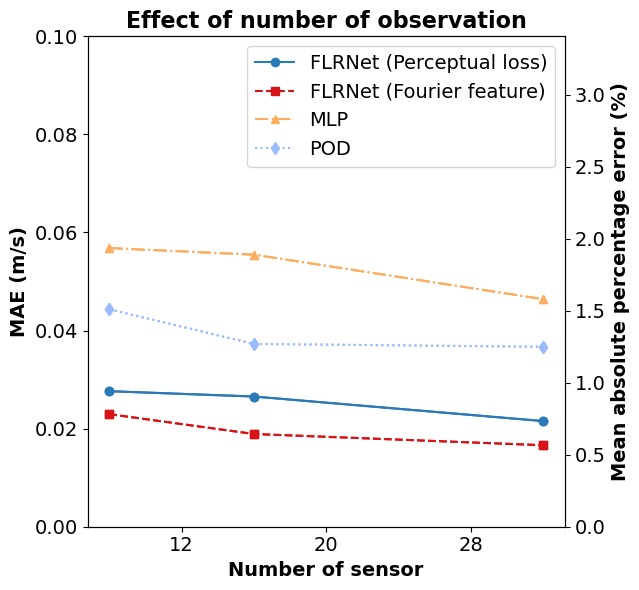

In [52]:
# Example Data: Replace these with your actual data
# Here, we'll create sample data for demonstration purposes
x = [8, 16, 32]  # X-axis values from 0 to 10
color = ['#2A7AB7', '#D71317','#FBAE60','#9ABBFE','#87C01B',]
mae_vae = np.mean(np.abs(gt_data-flr_net), axis = (1,2,3,4,5))
mae_fou = np.mean(np.abs(gt_data-flr_net_fourier), axis = (1,2,3,4,5))
mae_mlp = np.mean(np.abs(gt_data-mlp), axis = (1,2,3,4,5))
mae_pod = np.mean(np.abs(gt_data-pod), axis = (1,2,3,4,5))

# # Generate four different y datasets
# y1 = np.sin(x)              # Line 1: Sine wave
# y2 = np.cos(x)              # Line 2: Cosine wave
# y3 = np.sin(x) + np.cos(x)  # Line 3: Sum of sine and cosine
# y4 = np.sin(2 * x)          # Line 4: Sine wave with double frequency

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(6.5, 6))  # Set the figure size (optional)

# Plot each line with different styles
ax1.plot(x, mae_vae, label='FLRNet (Perceptual loss)', color=color[0], linestyle='-', linewidth=1.5,marker='o')
ax1.plot(x, mae_fou, label='FLRNet (Fourier feature)', color=color[1], linestyle='--', linewidth=1.5, marker='s')
ax1.plot(x, mae_mlp, label='MLP', color=color[2], linestyle='-.', linewidth=1.5, marker='^')
ax1.plot(x, mae_pod, label='POD', color=color[3], linestyle=':', linewidth=1.5, marker='d')
# ax1.set_ylim()
# Add titles and labels
plt.title('Effect of number of observation', fontsize=16, weight='bold')
plt.xlabel('Number of sensor', fontsize=14,weight='bold')
plt.ylabel('MAE (m/s)', fontsize=14,weight='bold')

# Add a legend
plt.legend(loc='upper right', fontsize=14)


# plt.axis('square')
# Add grid for better readability (optional)
# plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize the ticks (optional)
plt.xticks(np.arange(4, 44, 8), fontsize=12)  # X-axis ticks from 0 to 10
plt.yticks(np.arange(0, 0.12, 0.02), fontsize=12)  # Y-axis ticks from -2 to 2
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create the second y-axis for percentage representation
ax2 = ax1.twinx()

# Plot the same data but as percentages on the secondary y-axis
ax2.plot(x, mae_vae/max_val * 100, color=color[0], linestyle='-', linewidth=1.5,marker='o')
ax2.plot(x, mae_fou/max_val * 100, color=color[1], linestyle='--', linewidth=1.5, marker='s')
ax2.plot(x, mae_mlp/max_val * 100, color=color[2], linestyle='-.', linewidth=1.5, marker='^')
ax2.plot(x, mae_pod/max_val * 100, color=color[3], linestyle=':', linewidth=1.5, marker='d')

# ax2.plot(x, percentage_vae, color='green', linestyle='--', label='Percentage')
ax2.set_ylabel('Mean absolute percentage error (%)', color='black', fontsize=14, weight = 'bold')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([0, 0.1/max_val * 100])
ax2.tick_params(axis='both', which='major', labelsize=14)

# ax2.set_yticks(fontsize=12)
# Tight layout for better spacing
plt.tight_layout()
# plt.squar

# Display the plot
plt.savefig('no_of_sensor_effect.pdf')
plt.show()


## Effect of flow speed (Re) (Fig. 3)

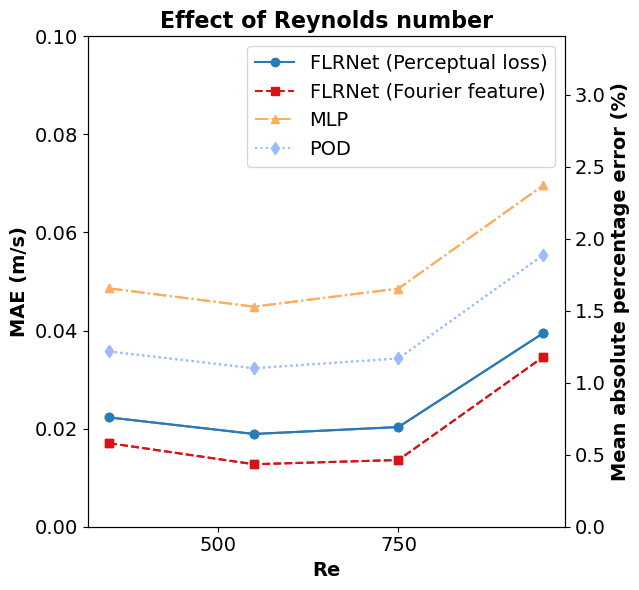

In [65]:
# Example Data: Replace these with your actual data
# Here, we'll create sample data for demonstration purposes
Re_list_test = [350, 550, 750, 950]
 # X-axis values from 0 to 10
color = ['#2A7AB7', '#D71317','#FBAE60','#9ABBFE','#87C01B',]
mae_vae = np.mean(np.abs(gt_data-flr_net), axis = (0,2,3,4,5))
mae_fou = np.mean(np.abs(gt_data-flr_net_fourier), axis = (0,2,3,4,5))
mae_mlp = np.mean(np.abs(gt_data-mlp), axis = (0,2,3,4,5))
mae_pod = np.mean(np.abs(gt_data-pod), axis = (0,2,3,4,5))


# # Generate four different y datasets
# y1 = np.sin(x)              # Line 1: Sine wave
# y2 = np.cos(x)              # Line 2: Cosine wave
# y3 = np.sin(x) + np.cos(x)  # Line 3: Sum of sine and cosine
# y4 = np.sin(2 * x)          # Line 4: Sine wave with double frequency

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(6.5, 6))  # Set the figure size (optional)

# Plot each line with different styles
ax1.plot(Re_list_test, mae_vae, label='FLRNet (Perceptual loss)', color=color[0], linestyle='-', linewidth=1.5,marker='o')
ax1.plot(Re_list_test, mae_fou, label='FLRNet (Fourier feature)', color=color[1], linestyle='--', linewidth=1.5, marker='s')
ax1.plot(Re_list_test, mae_mlp, label='MLP', color=color[2], linestyle='-.', linewidth=1.5, marker='^')
ax1.plot(Re_list_test, mae_pod, label='POD', color=color[3], linestyle=':', linewidth=1.5, marker='d')
# ax1.set_xlim([250,1250])
# Add titles and labels
plt.title('Effect of Reynolds number', fontsize=16, weight='bold')
plt.xlabel('Re', fontsize=14,weight='bold')
plt.ylabel('MAE (m/s)', fontsize=14,weight='bold')

# Add a legend
plt.legend(loc='upper right', fontsize=14)


# plt.axis('square')
# Add grid for better readability (optional)
# plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize the ticks (optional)
plt.xticks(np.arange(250, 1250, 250),fontsize=12)  # X-axis ticks from 0 to 10
plt.yticks(np.arange(0, 0.12, 0.02), fontsize=12)  # Y-axis ticks from -2 to 2
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create the second y-axis for percentage representation
ax2 = ax1.twinx()

# Plot the same data but as percentages on the secondary y-axis
ax2.plot(Re_list_test, mae_vae/max_val * 100, color=color[0], linestyle='-', linewidth=1.5,marker='o')
ax2.plot(Re_list_test, mae_fou/max_val * 100, color=color[1], linestyle='--', linewidth=1.5, marker='s')
ax2.plot(Re_list_test, mae_mlp/max_val * 100, color=color[2], linestyle='-.', linewidth=1.5, marker='^')
ax2.plot(Re_list_test, mae_pod/max_val * 100, color=color[3], linestyle=':', linewidth=1.5, marker='d')

# ax2.plot(x, percentage_vae, color='green', linestyle='--', label='Percentage')
ax2.set_ylabel('Mean absolute percentage error (%)', color='black', fontsize=14,weight='bold')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([0, 0.1/max_val * 100])
ax2.tick_params(axis='both', which='major', labelsize=14)

# Tight layout for better spacing
plt.tight_layout()
# plt.squar

# Display the plot
plt.savefig('Re_effect.pdf')
plt.show()

## Error in time

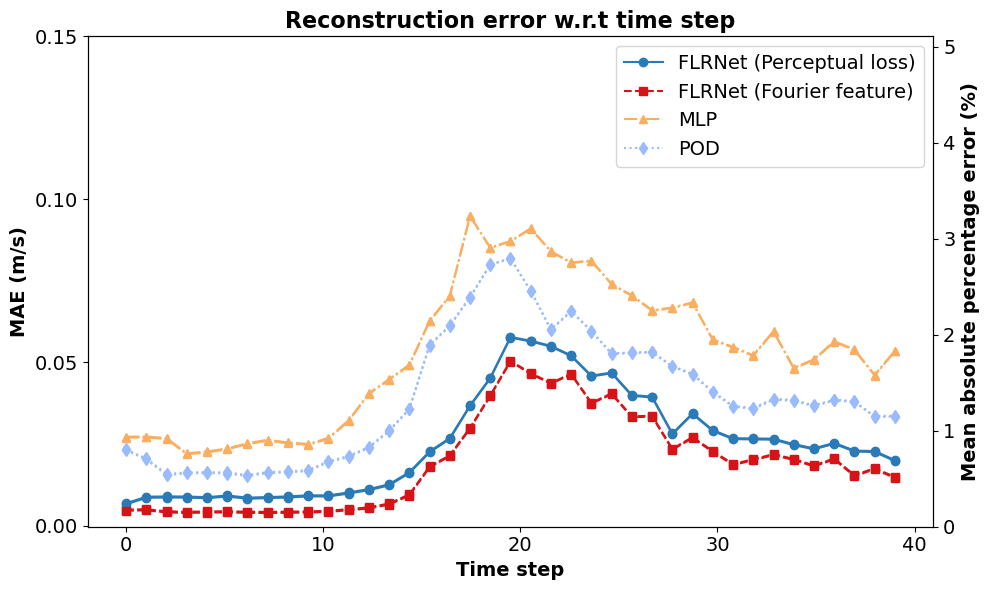

In [59]:
# Example Data: Replace these with your actual data
# Here, we'll create sample data for demonstration purposes
t = np.linspace(0,39,39) # X-axis values from 0 to 10
color = ['#2A7AB7', '#D71317','#FBAE60','#9ABBFE','#87C01B',]
mae_vae = np.mean(np.abs(gt_data-flr_net), axis = (0,1,3,4,5))
mae_fou = np.mean(np.abs(gt_data-flr_net_fourier), axis = (0,1,3,4,5))
mae_mlp = np.mean(np.abs(gt_data-mlp), axis = (0,1,3,4,5))
mae_pod = np.mean(np.abs(gt_data-pod), axis = (0,1,3,4,5))

# Create a figure and axis
fig,ax1 = plt.subplots(figsize=(10, 6))  # Set the figure size (optional)

# Plot each line with different styles
ax1.plot(t, mae_vae, label='FLRNet (Perceptual loss)', color=color[0], linestyle='-', linewidth=1.5,marker='o')
ax1.plot(t, mae_fou, label='FLRNet (Fourier feature)', color=color[1], linestyle='--', linewidth=1.5, marker='s')
ax1.plot(t, mae_mlp, label='MLP', color=color[2], linestyle='-.', linewidth=1.5, marker='^')
ax1.plot(t, mae_pod, label='POD', color=color[3], linestyle=':', linewidth=1.5, marker='d')

# Add titles and labels
plt.title('Reconstruction error w.r.t time step', fontsize=16, weight='bold')
plt.xlabel('Time step', fontsize=14,weight='bold')
plt.ylabel('MAE (m/s)', fontsize=14,weight='bold')

# Add a legend
plt.legend(loc='upper right', fontsize=14)


# plt.axis('square')
# Add grid for better readability (optional)
# plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize the ticks (optional)
plt.xticks(np.arange(0, 50, 10),fontsize=12)  # X-axis ticks from 0 to 10
plt.yticks(np.arange(0, 0.2, 0.05),fontsize=12)  # Y-axis ticks from -2 to 2
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create the second y-axis for percentage representation
ax2 = ax1.twinx()

# Plot the same data but as percentages on the secondary y-axis
ax2.plot(t, mae_vae/max_val * 100, color=color[0], linestyle='-', linewidth=1.5,marker='o')
ax2.plot(t, mae_fou/max_val * 100, color=color[1], linestyle='--', linewidth=1.5, marker='s')
ax2.plot(t, mae_mlp/max_val * 100, color=color[2], linestyle='-.', linewidth=1.5, marker='^')
ax2.plot(t, mae_pod/max_val * 100, color=color[3], linestyle=':', linewidth=1.5, marker='d')

# ax2.plot(x, percentage_vae, color='green', linestyle='--', label='Percentage')
ax2.set_ylabel('Mean absolute percentage error (%)', color='black', fontsize=14,weight='bold')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([0, 0.15/max_val * 100])
ax2.tick_params(axis='both', which='major', labelsize=14)

# Tight layout for better spacing
plt.tight_layout()
# plt.squar

# Display the plot
plt.savefig('temporal_analysis.pdf')
plt.show()

## Field reconstruction plot (Fig.5 - 7)

### Fig. 5 (1/4)

In [61]:
def field_plot(time, Re):
    case_id = 0
    time_idx = time
    fig, ax = plt.subplots(5, 3, figsize=(12, 10.5))
    title = "Field reconstruction of different methods for unsteady flow with Re = " + str(Re) + " at time step = " + str(time)
    fig.suptitle(title, fontsize=20, weight='bold')
    # First row: 1 image spanning all three columns

    img1 = ax[0, 1].imshow(gt_data[0, case_id, time_idx, :, :], vmin=0, vmax=2.5, cmap='Spectral_r')
    ax[0, 1].set_title("Ground truth",fontsize=18)
    ax[0, 1].axis("off")
    # Add a colorbar for the first row
    cbar_ax = fig.add_axes([0.64, 0.772, 0.02, 0.147])  # [left, bottom, width, height]
    cbar = fig.colorbar(img1, cax=cbar_ax)
    cbar.set_label(label= '(m/s)', weight="bold", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    #Hide the other two axes in the first row
    ax[0, 0].axis("off")
    ax[0, 2].axis("off")

    # Titles for each row
    row_titles = ["","FLRNet \n(w perceptual loss)", "FLRNet \n(w Fourier feature)", "MLP", "POD"]

    # Add titles to the left of each row
    for row in range(5):
        fig.text(0.0, 1 - (row + 1) * 0.18, row_titles[row], va='center', ha='right', fontsize=18)


    # FLRNet
    sensor_title = ["8 sensors","16 sensors", "32 sensors"]
    for col in range(3):
        ax[1, col].imshow(flr_net[0, case_id, time_idx, :, :], vmin=0, vmax=2.5, cmap='Spectral_r')
        ax[1, col].set_title(sensor_title[col],fontsize=18)
        ax[1, col].axis("off")


    # FLRNet
    for col in range(3):
        ax[2, col].imshow(flr_net_fourier[0, case_id, time_idx , :, :], vmin=0, vmax=2.5, cmap='Spectral_r')
        ax[2, col].axis("off")

    # FLRNet
    for col in range(3):
        ax[3, col].imshow(mlp[0, case_id, time_idx, :, :], vmin=0, vmax=2.5, cmap='Spectral_r')
        ax[3, col].axis("off")

    # FLRNet
    for col in range(3):
        ax[4, col].imshow(pod[0, case_id, time_idx, :, :], vmin=0, vmax=2.5, cmap='Spectral_r')
        ax[4, col].axis("off")

    plt.tight_layout()
    file_name = 'field_plot_' + str(time) +'.pdf'
    
    plt.savefig(file_name, bbox_inches='tight',  format="pdf")

    plt.show()

C:\Users\phong\AppData\Local\Temp\ipykernel_26768\2216147030.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


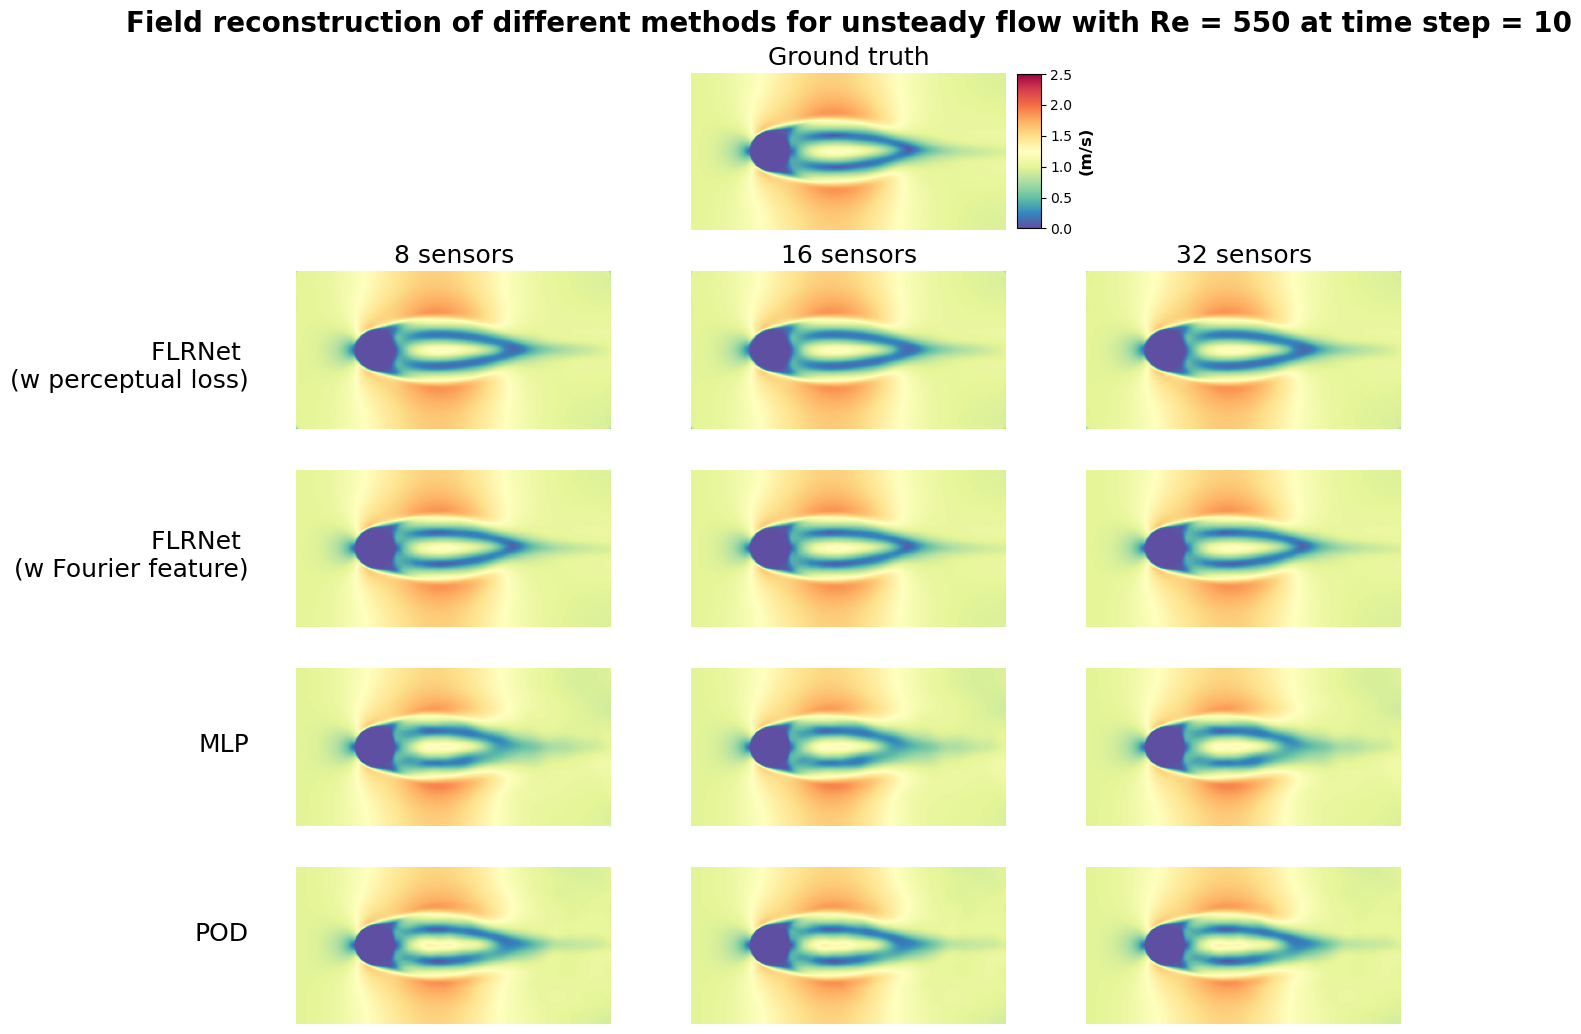

In [62]:
field_plot(time = int(39/4+1), Re = 550)

### Fig. 6

C:\Users\phong\AppData\Local\Temp\ipykernel_26768\2216147030.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


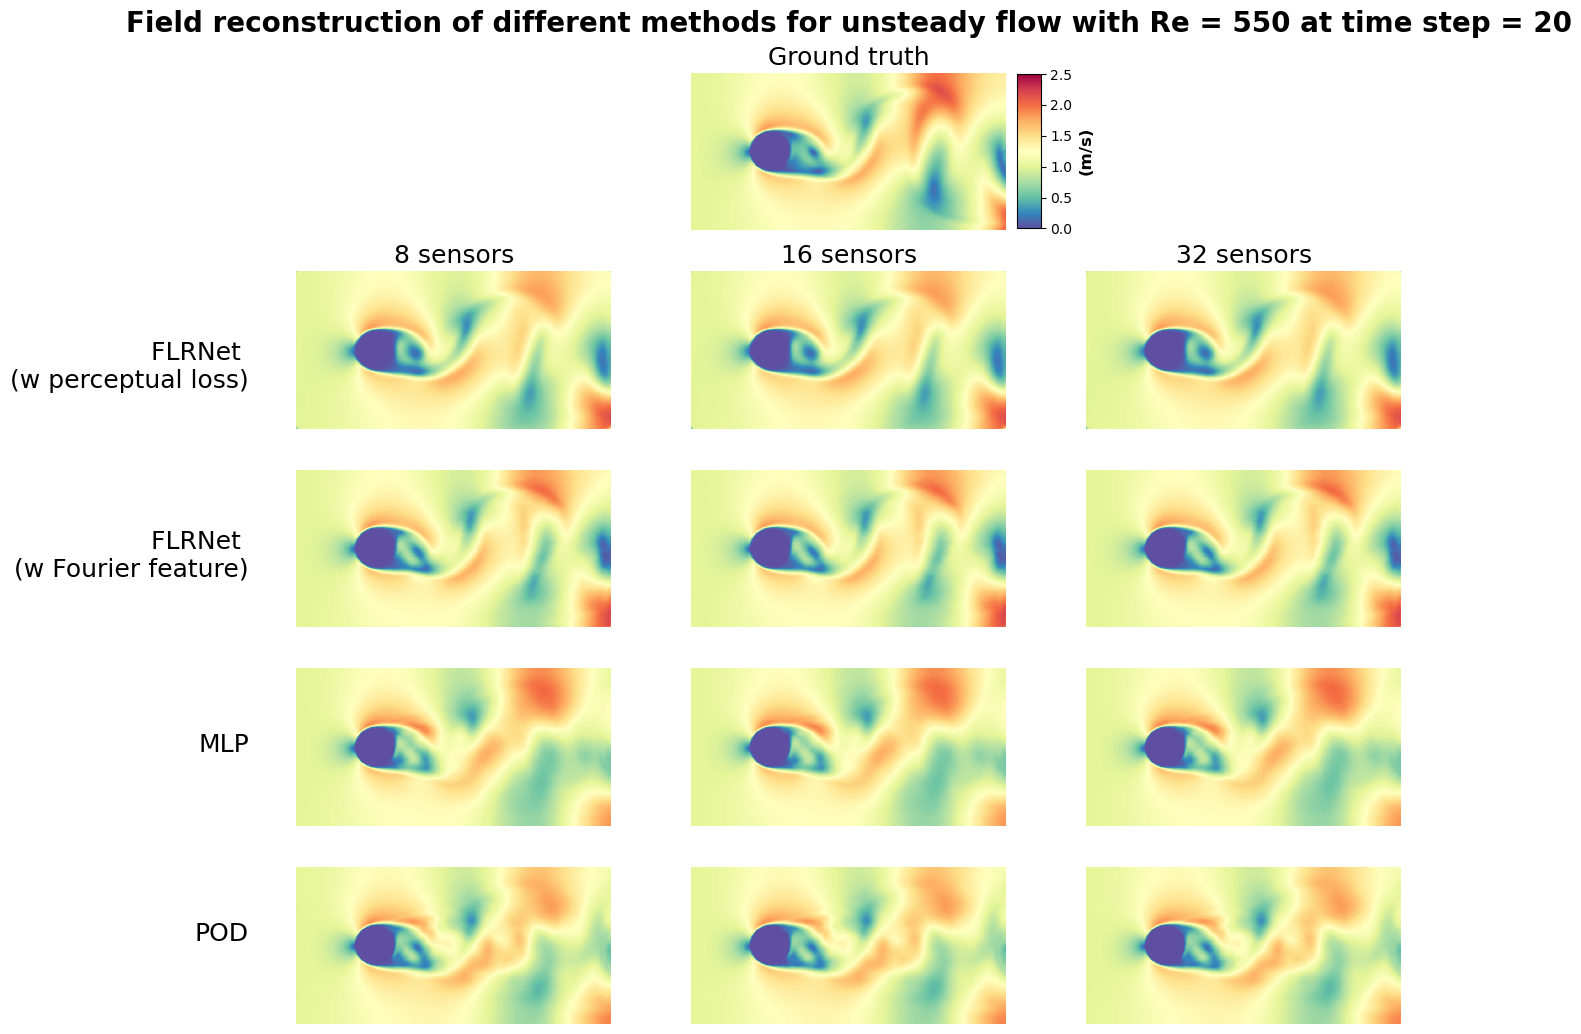

In [63]:
field_plot(time= int(39/4*2 + 1), Re = 550)

### Fig. 7 

C:\Users\phong\AppData\Local\Temp\ipykernel_26768\2216147030.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


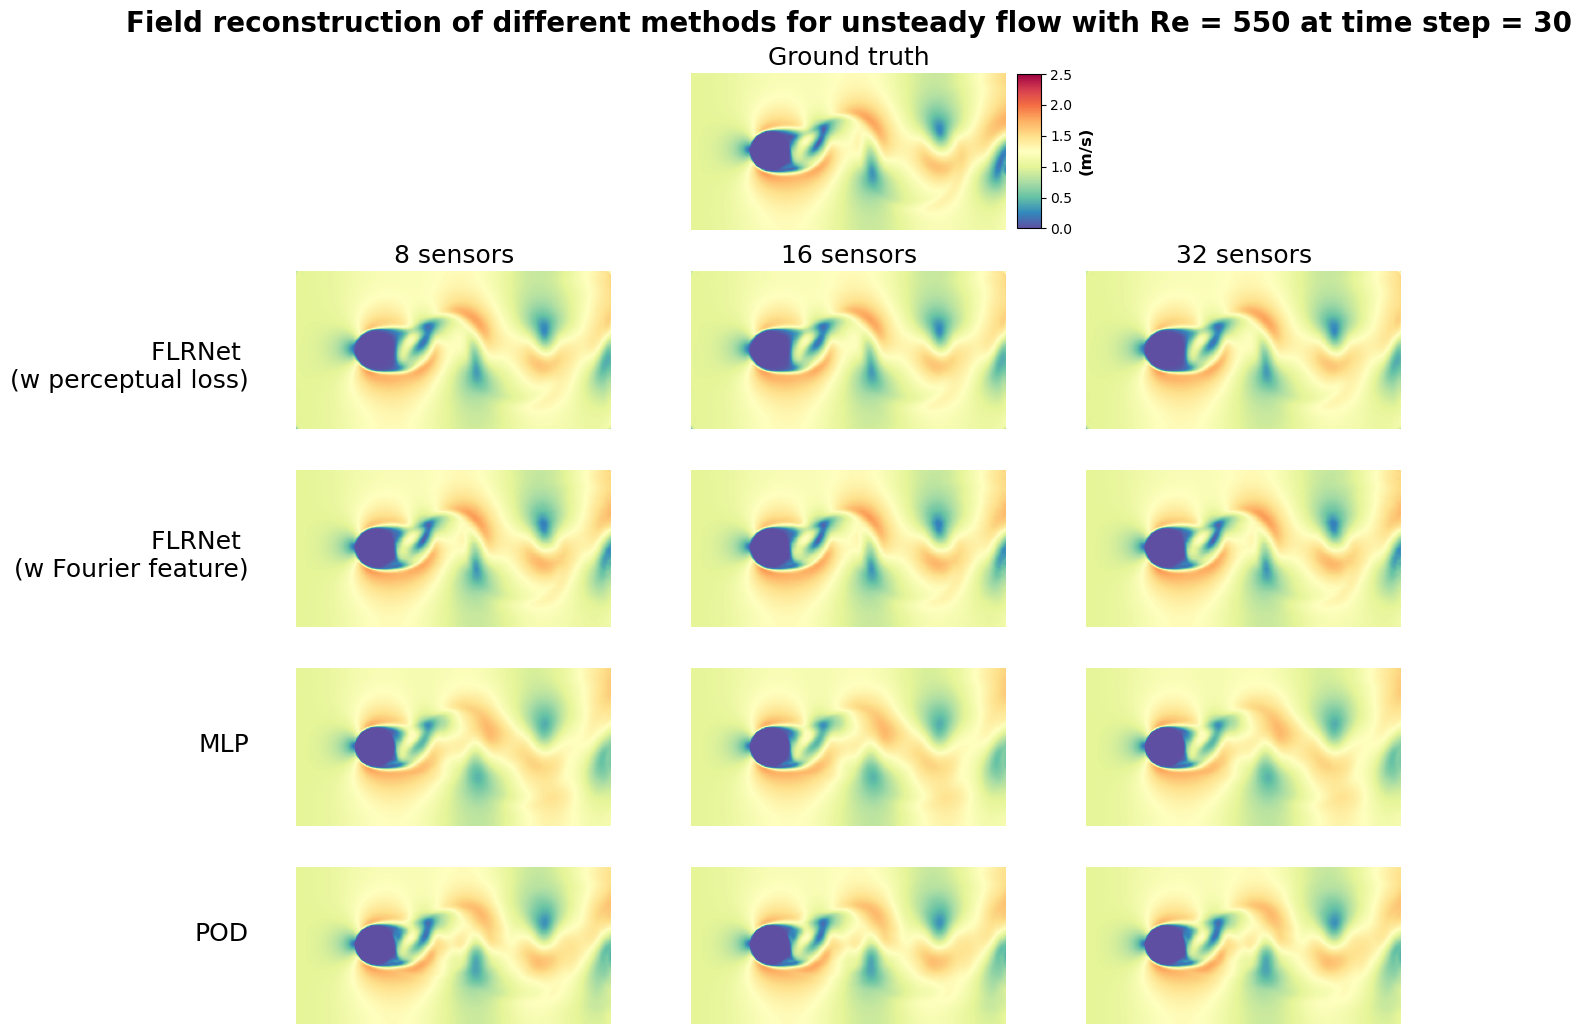

In [64]:
field_plot(time= int(39/4*3+ 1), Re = 550)

## Fig. 8 (vertical profile)

In [55]:
mae_vae = np.mean(np.abs(gt_data-flr_net), axis = (0,1))
mae_fou = np.mean(np.abs(gt_data-flr_net_fourier), axis = (0,1))
mae_mlp = np.mean(np.abs(gt_data-mlp), axis = (0,1))
mae_pod = np.mean(np.abs(gt_data-pod), axis = (0,1))

In [109]:
mae_fou.shape

(39, 128, 256, 1)

In [86]:
# Example Data: Replace these with your actual data
# Here, we'll create sample data for demonstration purposes
def vertical_error_profile(pos):
    time= int(39/4*2 + 1)
    y = np.linspace(0,128,128) # X-axis values from 0 to 10
    x_pos = int(256/7*pos)
    color = ['#2A7AB7', '#D71317','#FBAE60','#9ABBFE','#87C01B',]


    # Create a figure and axis
    plt.figure(figsize=(6, 6))  # Set the figure size (optional)

    # Plot each line with different styles
    plt.plot(y, mae_vae[time,:,x_pos,0], label='FLRNet (Perceptual loss)', color=color[0], linestyle='-', linewidth=2)
    plt.plot(y, mae_fou[time,:,x_pos,0], label='FLRNet (Fourier feature)', color=color[1], linestyle='--', linewidth=2)
    plt.plot(y, mae_mlp[time,:,x_pos,0], label='MLP', color=color[2], linestyle='-.', linewidth=2)
    plt.plot(y, mae_pod[time,:,x_pos,0], label='POD', color=color[3], linestyle=':', linewidth=2)

    # Add titles and labels
    title = 'Error profile at pos #' + str(pos)
    plt.title(title, fontsize=20, weight='bold')
    plt.xlabel('y', fontsize=20,weight='bold')
    plt.ylabel('MAE (m/s)', fontsize=20,weight='bold')

    # Add a legend
    plt.legend(loc='upper right', fontsize=20)


    # plt.axis('square')
    # Add grid for better readability (optional)
    # plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Customize the ticks (optional)
    plt.xticks(np.arange(0, 160, 32),fontsize=18)  # X-axis ticks from 0 to 10
    plt.yticks(np.arange(0.0, 0.45, 0.1),fontsize=18)  # Y-axis ticks from -2 to 2

    # Tight layout for better spacing
    plt.tight_layout()
    # plt.squar

    # Display the plot
    file_name = 'profile_' + str(pos) + '.svg'
    plt.savefig(file_name)
    plt.show()

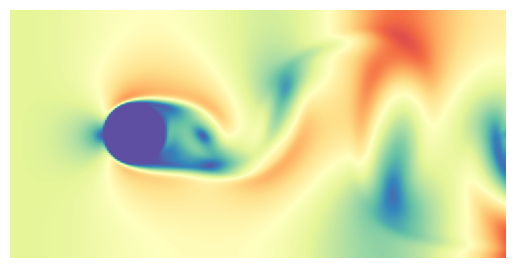

In [78]:
fig, ax = plt.subplots()
ax.imshow(gt_data[0,0,int(39/4*2 + 1),:,:,0], vmin = 0, vmax = 2.5, cmap= 'Spectral_r')
ax.axis("off")
plt.savefig('field_plot.svg')

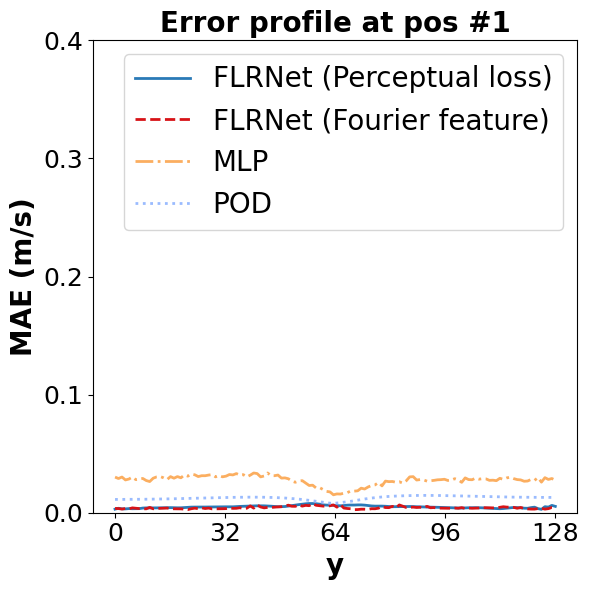

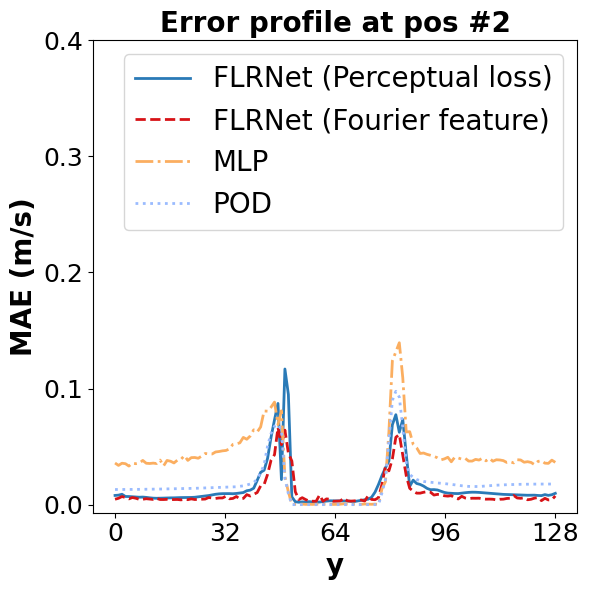

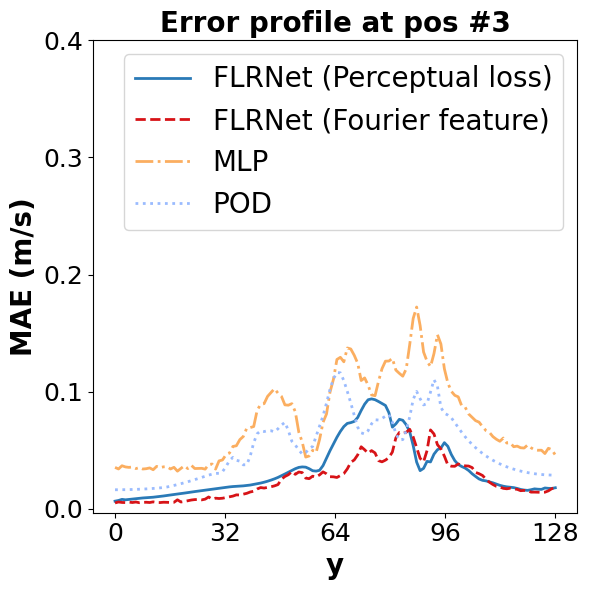

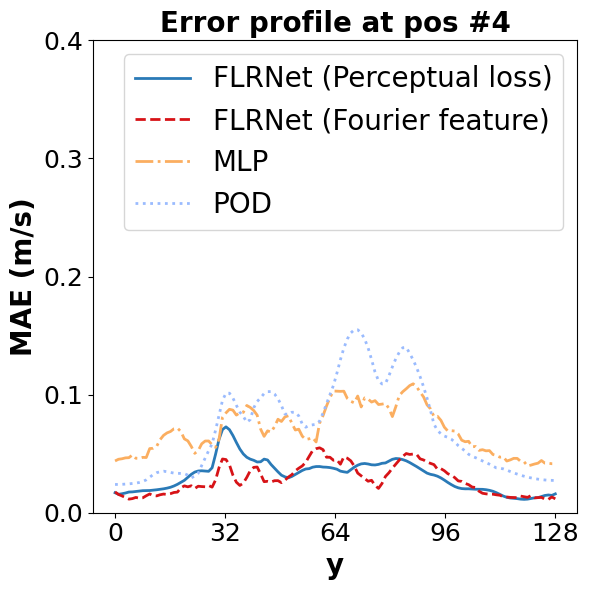

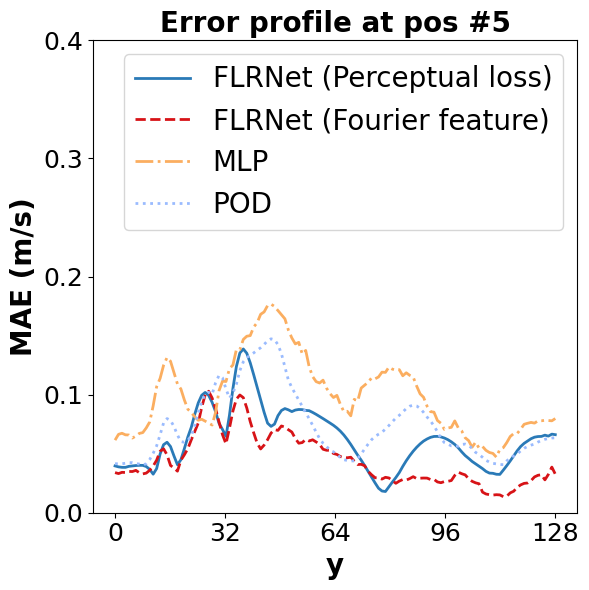

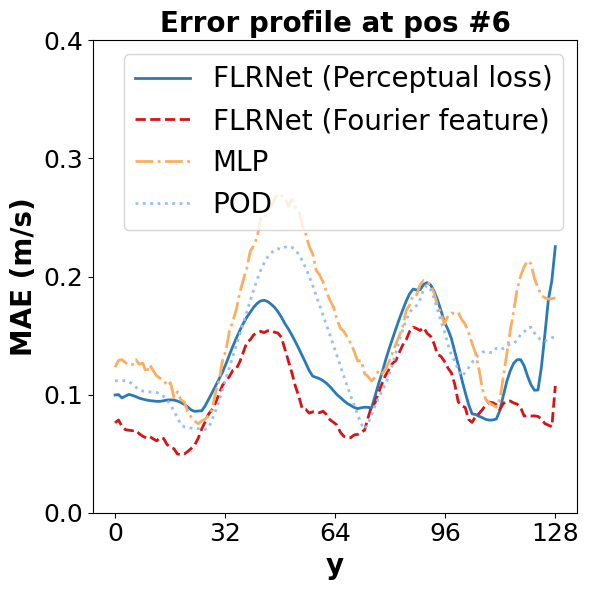

In [87]:
vertical_error_profile(pos = 1)
vertical_error_profile(pos = 2)
vertical_error_profile(pos = 3)
vertical_error_profile(pos = 4)
vertical_error_profile(pos = 5)
vertical_error_profile(pos = 6)